### Projeto 1 - Engenharia do Conhecimento 2023/2024
#### Trabalho realizador por: **Grupo 19:**
##### 58180 - Rodrigo Correia; 58188 - Laura Cunha; 58223 - Martim Pereira
---

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC, LinearSVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, r2_score, explained_variance_score, root_mean_squared_error, mean_absolute_error, matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler
from ydata_profiling import ProfileReport
from xgboost import XGBClassifier

In [4]:
data_df = pd.read_csv('proj-data.csv') # Ler o dataset

### Preprocessamento de Dados

In [5]:
def categorize_diagnosis(diagnosis): # Categorizar as classes do target (diagnoses)
    if len(diagnosis) > 1 or diagnosis in ['O', 'P', 'Q', 'S', 'T']:
        return 'other conditions'
    elif diagnosis in ['A', 'B', 'C', 'D']:
        return 'hyperthyroid conditions'
    elif diagnosis in ['E', 'F', 'G', 'H']:
        return 'hypothyroid conditions'
    elif diagnosis in ['I', 'J']:
        return 'binding protein'
    elif diagnosis == 'K':
        return 'general health'
    elif diagnosis in ['L', 'M', 'N']:
        return 'replacement therapy'
    elif diagnosis == 'R':
        return 'discordant results'
    else:
        return 'healthy'
    
data_df['target'] = data_df['diagnoses'].apply(categorize_diagnosis)
data_df.drop(['diagnoses'], axis=1, inplace=True)

In [6]:
# Tartar os dados
data_df.drop(['[record identification]'], axis=1, inplace=True)
data_df = data_df.replace('?', np.nan)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = data_df.replace({'f': 0, 't': 1, 'M':0, 'F':1})
continuous_cols = ['TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']
data_df[continuous_cols] = data_df[continuous_cols].apply(pd.to_numeric, errors='coerce', axis=1)

### EDA

In [7]:
# profile = ProfileReport(data_df)  # Geração do relatório do ydata_profiling
# profile.to_file('profile.html')
# Através da análise do relatório, decidiu-se realizar o seguinte processamento dos dados:

In [8]:
data_df = data_df[data_df['age:'] < 100]
data_df.drop(['hypopituitary:'], axis=1, inplace=True)
miss_values_cols = ['TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']
for i in miss_values_cols:
    data_df[i] = data_df[i].fillna(-1)
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
referral_encoded = ohe_enc.fit_transform(data_df[['referral source:']])
data_df = pd.concat([data_df, referral_encoded], axis=1).drop(columns=['referral source:'])
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)

In [9]:
def test_models(X_train, X_test, y_train, y_test, aval_type): # Executa os varios modelos com um feature selection 'forward' e imprime a tabela com os resultados
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        classification_models = [KNeighborsClassifier(n_jobs=-1), SVC(random_state=19), GaussianNB(), MLPClassifier(max_iter=9999999, random_state=19), AdaBoostClassifier(algorithm='SAMME', random_state=19), RandomForestClassifier(n_jobs=-1, random_state=19), DecisionTreeClassifier(random_state=19), XGBClassifier()]
        regression_models = [RandomForestRegressor(random_state=19, n_jobs=-1), KNeighborsRegressor(n_jobs=-1), DecisionTreeRegressor(random_state=19), LinearRegression(n_jobs=-1), LinearSVR(dual='auto', max_iter=9999999, random_state=19), RidgeCV(alphas=np.linspace(0.01, .99, 100)), ElasticNetCV(alphas=np.linspace(0.01, .99, 100), max_iter=9999999, random_state=19), LassoCV(alphas=np.linspace(0.01, .99, 100), max_iter=9999999, random_state=19)]
        scalers = [None, StandardScaler(), MinMaxScaler(), PowerTransformer()]
        models = regression_models if aval_type == 'age' else classification_models
        models_sfs = {}
        if aval_type == 'target':
            print(f'{"Model name":<45} | {"Recall avg":<11} | {"F1 avg":<7} | Accuracy')
        elif aval_type == 'sex':
            print(f'{"Model name":<45} | {"MCC":<11} | {"F1 avg":<7} | Accuracy')
        else:
            print(f'{"Model name":<45} | {"R2":<6} | {"RMSE":<6} | {'MAE':<6} | EVS')
        scoring_type = 'f1_macro' if aval_type == 'sex' or aval_type == 'target' else 'neg_mean_squared_error'
        for model in models:
            sfs = SequentialFeatureSelector(model, n_features_to_select=8, scoring=scoring_type,n_jobs=-1).set_output(transform="pandas")
            sfs.fit(X_train, y_train)
            models_sfs[model.__class__.__name__] = sfs
            n_train = sfs.transform(X_train)
            n_test = sfs.transform(X_test)
            for scaler in scalers:
                pipe = Pipeline([('scaler', scaler), ('model', model)])
                pipe.fit(n_train, y_train)
                y_pred = pipe.predict(n_test)
                model_scaler_name = f'{model.__class__.__name__} ({scaler.__class__.__name__})'
                if aval_type == 'target' or aval_type == 'sex':
                    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
                    acc = accuracy_score(y_test, y_pred)
                    if aval_type == 'target':
                        recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
                        print(f'{model_scaler_name:<45} | {np.round(recall, 3):<11} | {np.round(f1, 3):<7} | {np.round(acc, 3)}')
                    else:
                        mcc = matthews_corrcoef(y_test, y_pred)
                        print(f'{model_scaler_name:<45} | {np.round(mcc, 3):<11} | {np.round(f1, 3):<7} | {np.round(acc, 3)}')
                else:
                    print(f'{model_scaler_name:<45} | {np.round(r2_score(y_test, y_pred), 3):<6} | {np.round(root_mean_squared_error(y_test, y_pred), 3):<6} | {np.round(mean_absolute_error(y_test, y_pred), 3):<6} | {np.round(explained_variance_score(y_test, y_pred), 3)}')
        return models_sfs

In [10]:
def tune_model(model, param_grid, X_train, y_train, model_type): # Executa o gridsearch com os hyperparametros dos respetivos modelos
    scoring_type = 'f1_macro' if model_type == 'classification' else 'r2'
    grid = GridSearchCV(model, param_grid, cv=10, n_jobs=-1, scoring=scoring_type)
    grid.fit(X_train, y_train)
    print("Best hyperparameters:", grid.best_params_)
    print("Best score", '(F1 macro):' if model_type == 'classification' else '(R2):', grid.best_score_)

### Modelação
### > O1

In [9]:
X = data_df.drop(['target'], axis=1)
y = LabelEncoder().fit_transform(data_df['target'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=19)

In [10]:
models_sfs = test_models(X_train, X_test, y_train, y_test, 'target')

Model name                                    | Recall avg  | F1 avg  | Accuracy
KNeighborsClassifier (NoneType)               | 0.486       | 0.52    | 0.84
KNeighborsClassifier (StandardScaler)         | 0.659       | 0.711   | 0.892
KNeighborsClassifier (MinMaxScaler)           | 0.599       | 0.663   | 0.867
KNeighborsClassifier (PowerTransformer)       | 0.637       | 0.684   | 0.884
SVC (NoneType)                                | 0.351       | 0.36    | 0.806
SVC (StandardScaler)                          | 0.302       | 0.319   | 0.795
SVC (MinMaxScaler)                            | 0.156       | 0.162   | 0.752
SVC (PowerTransformer)                        | 0.305       | 0.315   | 0.791
GaussianNB (NoneType)                         | 0.486       | 0.482   | 0.774
GaussianNB (StandardScaler)                   | 0.486       | 0.482   | 0.774
GaussianNB (MinMaxScaler)                     | 0.486       | 0.482   | 0.774
GaussianNB (PowerTransformer)                 | 0.504       | 

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 5, 10, 15],
}
n_train = models_sfs[RandomForestClassifier().__class__.__name__].transform(X_train)
print('Best features:', ', '.join(list(n_train.columns)))
tune_model(RandomForestClassifier(n_jobs=-1, random_state=19), param_grid, n_train, y_train, 'classification')

Best features: on thyroxine:, on antithyroid medication:, TSH:, T3:, TT4:, T4U:, FTI:, TBG:
Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score (F1 macro): 0.8589225259476176


### > O2_Sexo

In [12]:
X = data_df.drop(['sex:'], axis=1)
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
target_encoded = ohe_enc.fit_transform(X[['target']])
X = pd.concat([X, target_encoded], axis=1).drop(columns=['target'])
y = data_df['sex:']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
rand = RandomUnderSampler(random_state=19)
X_train, y_train = rand.fit_resample(X_train, y_train)

In [13]:
models_sfs = test_models(X_train, X_test, y_train, y_test, 'sex')

Model name                                    | MCC         | F1 avg  | Accuracy
KNeighborsClassifier (NoneType)               | 0.153       | 0.561   | 0.583
KNeighborsClassifier (StandardScaler)         | 0.209       | 0.586   | 0.604
KNeighborsClassifier (MinMaxScaler)           | 0.214       | 0.591   | 0.611
KNeighborsClassifier (PowerTransformer)       | 0.212       | 0.587   | 0.604
SVC (NoneType)                                | 0.281       | 0.612   | 0.623
SVC (StandardScaler)                          | 0.278       | 0.613   | 0.626
SVC (MinMaxScaler)                            | 0.228       | 0.606   | 0.634
SVC (PowerTransformer)                        | 0.294       | 0.615   | 0.624
GaussianNB (NoneType)                         | 0.214       | 0.603   | 0.638
GaussianNB (StandardScaler)                   | 0.214       | 0.603   | 0.638
GaussianNB (MinMaxScaler)                     | 0.214       | 0.603   | 0.638
GaussianNB (PowerTransformer)                 | 0.22        |

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
n_train = models_sfs[AdaBoostClassifier().__class__.__name__].transform(X_train)
print('Best features:', ', '.join(list(n_train.columns)))
tune_model(AdaBoostClassifier(algorithm='SAMME', random_state=19), param_grid, n_train, y_train, 'classification')

Best features: query hyperthyroid:, tumor:, TT4 measured:, T4U:, referral source:_STMW, referral source:_SVHC, referral source:_SVI, referral source:_other
Best hyperparameters: {'learning_rate': 0.5, 'n_estimators': 500}
Best score (F1 macro): 0.6441159536952934


### > O2_Idade

In [11]:
X = data_df.drop(['age:'], axis=1)
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
target_encoded = ohe_enc.fit_transform(X[['target']])
X = pd.concat([X, target_encoded], axis=1).drop(columns=['target'])
y = data_df['age:']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [12]:
models_sfs = test_models(X_train, X_test, y_train, y_test, 'age') # Executar os vários modelos, obtendo as suas métricas.

Model name                                    | R2     | RMSE   | MEA    | EVS
RandomForestRegressor (NoneType)              | 0.133  | 17.583 | 14.542 | 0.133
RandomForestRegressor (StandardScaler)        | 0.133  | 17.583 | 14.542 | 0.133
RandomForestRegressor (MinMaxScaler)          | 0.133  | 17.583 | 14.542 | 0.133
RandomForestRegressor (PowerTransformer)      | 0.133  | 17.583 | 14.542 | 0.133
KNeighborsRegressor (NoneType)                | -0.06  | 19.436 | 15.802 | 0.017
KNeighborsRegressor (StandardScaler)          | 0.104  | 17.873 | 15.0   | 0.104
KNeighborsRegressor (MinMaxScaler)            | -0.06  | 19.436 | 15.802 | 0.017
KNeighborsRegressor (PowerTransformer)        | 0.104  | 17.873 | 15.0   | 0.104
DecisionTreeRegressor (NoneType)              | 0.133  | 17.581 | 14.547 | 0.133
DecisionTreeRegressor (StandardScaler)        | 0.133  | 17.581 | 14.547 | 0.133
DecisionTreeRegressor (MinMaxScaler)          | 0.133  | 17.581 | 14.547 | 0.133
DecisionTreeRegressor (PowerTr

In [13]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 50, 70, 100],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 50],
    'min_samples_split': range(2, 40)
}
n_train = models_sfs[DecisionTreeRegressor().__class__.__name__].transform(X_train)
print('Best features:', ', '.join(list(n_train.columns)))
tune_model(DecisionTreeRegressor(random_state=19), param_grid, n_train, y_train, 'regression')

Best features: sick:, I131 treatment:, goitre:, TSH measured:, referral source:_STMW, referral source:_SVHC, referral source:_SVI, target_general health
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 31}
Best score (R2): 0.13023933634449394


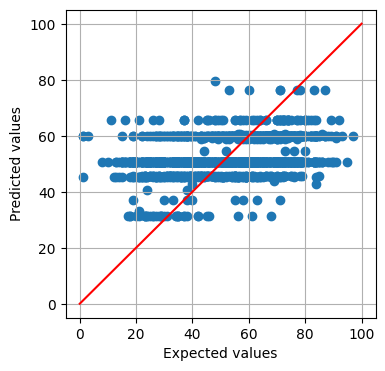

In [15]:
model = DecisionTreeRegressor(min_samples_split=31, random_state=19)
model.fit(n_train, y_train)
n_test = models_sfs[model.__class__.__name__].transform(X_test)
y_preds = model.predict(n_test)
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_preds)
plt.grid()
plt.plot([0, 100], [0, 100], c="r")
plt.xlabel("Expected values") 
plt.ylabel("Predicted values")
plt.show()

### Última célula 

In [ ]:
import pandas as pd
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, root_mean_squared_error, max_error, r2_score, mean_absolute_error
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
ohe_enc_refer = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
ohe_enc_target_age = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
ohe_enc_target_sex = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')

def categorize_diagnosis(diagnosis):
    if len(diagnosis) > 1 or diagnosis in ['O', 'P', 'Q', 'S', 'T']:
        return 'other conditions'
    elif diagnosis in ['A', 'B', 'C', 'D']:
        return 'hyperthyroid conditions'
    elif diagnosis in ['E', 'F', 'G', 'H']:
        return 'hypothyroid conditions'
    elif diagnosis in ['I', 'J']:
        return 'binding protein'
    elif diagnosis == 'K':
        return 'general health'
    elif diagnosis in ['L', 'M', 'N']:
        return 'replacement therapy'
    elif diagnosis == 'R':
        return 'discordant results'
    else:
        return 'healthy'
    
def printRegStatistics(truth, preds):
    print("The R2 is: ", r2_score(truth, preds))
    print("The rmse is: ", root_mean_squared_error(truth, preds))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def parse_target_dataset(df):
    df['target'] = df['diagnoses'].apply(categorize_diagnosis)
    df.drop(['diagnoses'], axis=1, inplace=True)

def parse_dataset(df, is_train=False):
    df.drop(['[record identification]'], axis=1, inplace=True)
    df = df.replace('?', np.nan)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = df.replace({'f': 0, 't': 1, 'M':0, 'F':1}) 
    continuous_cols = ['TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']
    df[continuous_cols] = df[continuous_cols].apply(pd.to_numeric, errors='coerce', axis=1)
    df.drop(['hypopituitary:'], axis=1, inplace=True)
    miss_values_cols = ['TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']
    for i in miss_values_cols:
        df[i] = df[i].fillna(-1)
    if is_train:
        referral_encoded = ohe_enc_refer.fit_transform(df[['referral source:']])
    else:
        referral_encoded = ohe_enc_refer.transform(df[['referral source:']])
    df = pd.concat([df, referral_encoded], axis=1).drop(columns=['referral source:'])
    return df

def parse_train_dataset(df):
    df = df[df['age:'] < 100]
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df

def run_model(model, X_test, y_test, type='classification'):
    y_preds = model.predict(X_test)
    if type == 'classification':
        print(classification_report(y_test, y_preds, zero_division=0))
    else:
        printRegStatistics(y_test, y_preds)

def split_dataset(target_col):
    X = data_df.drop([target_col], axis=1)
    y = data_df[target_col]
    X_train,_,y_train,_ = train_test_split(X,y,test_size=0.2, random_state=19)
    return X_train, y_train
    
best_features_o1 = ['on thyroxine:', 'on antithyroid medication:', 'TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']
best_features_o2_age = ['sick:', 'I131 treatment:', 'goitre:', 'TSH measured:', 'referral source:_STMW', 'referral source:_SVHC', 'referral source:_SVI', 'target_general health']
best_features_o2_sex = ['query hyperthyroid:', 'tumor:', 'TT4 measured:', 'T4U:', 'referral source:_STMW', 'referral source:_SVHC', 'referral source:_SVI', 'referral source:_other']
data_df = pd.read_csv('proj-data.csv')
parse_target_dataset(data_df)
data_df = parse_train_dataset(parse_dataset(data_df, True))
X_train_o1, y_train_o1 = split_dataset('target')
X_train_o1 = X_train_o1[best_features_o1]
X_train_o2_age, y_train_o2_age = split_dataset('age:')
target_enc = ohe_enc_target_age.fit_transform(X_train_o2_age[['target']])
X_train_o2_age = pd.concat([X_train_o2_age, target_enc], axis=1).drop(columns=['target'])
X_train_o2_age = X_train_o2_age[best_features_o2_age]
X_train_o2_sex, y_train_o2_sex = split_dataset('sex:')
target_enc = ohe_enc_target_sex.fit_transform(X_train_o2_sex[['target']])
X_train_o2_sex = pd.concat([X_train_o2_sex, target_enc], axis=1).drop(columns=['target'])
rand = RandomUnderSampler(random_state=19)
X_train_o2_sex, y_train_o2_sex = rand.fit_resample(X_train_o2_sex, y_train_o2_sex)
X_train_o2_sex = X_train_o2_sex[best_features_o2_sex]
X_test_o1 = pd.read_csv('proj-test-data.csv')
X_test_o1 = parse_dataset(X_test_o1)
X_test_o2_age = pd.read_csv('proj-test2-data.csv')
parse_target_dataset(X_test_o2_age)
X_test_o2_age = parse_dataset(X_test_o2_age)
target_enc = ohe_enc_target_age.transform(X_test_o2_age[['target']])
X_test_o2_age = pd.concat([X_test_o2_age, target_enc], axis=1).drop(columns=['target'])
X_test_o2_sex = pd.read_csv('proj-test3-data.csv')
parse_target_dataset(X_test_o2_sex)
X_test_o2_sex = parse_dataset(X_test_o2_sex)
target_enc = ohe_enc_target_sex.transform(X_test_o2_sex[['target']])
X_test_o2_sex = pd.concat([X_test_o2_sex, target_enc], axis=1).drop(columns=['target'])
y_test_o1 = pd.read_csv('proj-test-class.csv')
parse_target_dataset(y_test_o1)
y_test_o2_age = pd.read_csv('proj-test2-age.csv')
y_test_o2_sex = pd.read_csv('proj-test3-sex.csv')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_test_o2_sex.replace({'F': 1, 'M': 0}, inplace=True)
model_o1 = RandomForestClassifier(max_depth=15, min_samples_leaf=1, n_estimators=100, random_state=19, n_jobs=-1).fit(X_train_o1, y_train_o1)
X_test_o1 = X_test_o1[best_features_o1]
run_model(model_o1, X_test_o1, y_test_o1)
print('-'*100)
model_age = DecisionTreeRegressor(min_samples_split=31, random_state=19).fit(X_train_o2_age, y_train_o2_age)
X_test_o2_age = X_test_o2_age[best_features_o2_age]
run_model(model_age, X_test_o2_age, np.squeeze(np.asarray(y_test_o2_age)), 'regression')
print('-'*100)
model_sex = AdaBoostClassifier(algorithm='SAMME', random_state=19).fit(X_train_o2_sex, y_train_o2_sex)
X_test_o2_sex = X_test_o2_sex[best_features_o2_sex]
run_model(model_sex, X_test_o2_sex, y_test_o2_sex)